### prepare


In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
import time
from typing import List
from pathlib import Path
import pickle

import hydra
from omegaconf import DictConfig

import gym
from gym.spaces import Box

import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import torch
import seaborn as sns
from cycler import cycler


from d3rlpy.algos import SAC
from d3rlpy.algos import DoubleDQN as DDQN
from d3rlpy.algos import CQL
from d3rlpy.algos import IQL
from d3rlpy.algos import BCQ
from d3rlpy.algos import DiscreteCQL
from d3rlpy.algos import DiscreteBCQ
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import BaseHead
from scope_rl.policy import GaussianHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.policy import TrainCandidatePolicies

from scope_rl.ope.online import visualize_on_policy_policy_value
from scope_rl.ope.online import calc_on_policy_policy_value

from scope_rl.utils import MinMaxActionScaler
from scope_rl.utils import OldGymAPIWrapper
from scope_rl.types import LoggedDataset

from experiments.utils import torch_seed, format_runtime

from basicgym import BasicEnv

from tutorial.function import train_behavior_policy
from tutorial.function import obtain_logged_dataset
from tutorial.function import train_candidate_policies
# from experiments.main import off_policy_evaluation
from tutorial.function import off_policy_evaluation

### function

In [4]:
def visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    estimators,
    ESTIMATORS,
    x_scales,
    x_label,
    yscale_log = False,
    xscale_log = False,
):

    color_dict = {
        "red": "#E24A33",
        "blue": "#348ABD",
        "purple": "#988ED5",
        "gray": "#777777",
        "green": "#8EBA42",
        "yellow": "#FBC15E",
        "pink": "#FFB5B8",
        "brown": "#8c564b",
        "light blue": "#17becf",
        "olive": "#bcbd22",
    }
    cd = color_dict

    plt.style.use("ggplot")
    colors = [cd["red"], cd["blue"], cd["purple"], cd["gray"], cd["yellow"], cd['green'], cd['pink'], cd['brown'], cd['light blue'], cd['olive']]
    # plt.rcParams["axes.prop_cycle"] = cycler(color=colors)
    markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]
    # colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    n_colors = len(colors)

    log_dir="../tutorial/logs_epsilon=0.5/"

    metric_list = ['bias', 'variance', 'mse']

    for metric in metric_list:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
        if metric =='bias':
            result_df = bias_result_df
        elif metric == 'variance':
            result_df = variance_result_df
        else:
            result_df = mse_result_df

        for i, estimator in enumerate(estimators):
            data = result_df[result_df['est']==estimator]
            data = data.query(f"({min(x_scales)}<= {x_label} <= {max(x_scales)})")
            ax.plot(
                np.array([200, 400, 800, 1600, 3200, 4800, 6400, 8000]),
                data[metric],
                color=colors[i],
                marker=markers[i],
                label=ESTIMATORS[i],
            )
            
            ax.legend(ESTIMATORS, loc="upper right", fontsize=20)

            ax.fill_between(
                np.array([200, 400, 800, 1600, 3200, 4800, 6400, 8000]),
                data['lower'],
                data['upper'],
                color=colors[i % n_colors],
                alpha=0.3,
                label='',
            )

        # title and legend
        ax.legend(loc="upper right", fontsize=20)
        # yaxis
        if yscale_log:
            ax.set_yscale("log")
        ax.set_ylabel(metric, fontsize=25)
        ax.tick_params(axis="y", labelsize=15)
        ax.yaxis.set_label_coords(-0.08, 0.5)
        # xaxis
        if xscale_log:
            ax.set_xscale("log")
        ax.set_xlabel(f"number of {x_label}", fontsize=25)
        ax.set_xticks(x_scales)
        ax.set_xticklabels(x_scales, fontsize=15)
        ax.xaxis.set_label_coords(0.5, -0.1)

        path_ = Path(log_dir + "results/fig")
        path_.mkdir(exist_ok=True, parents=True)
        save_path = Path(path_ / f"{metric}_result_fig_{x_label}_{ESTIMATORS}.png")
        fig.tight_layout()
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

In [21]:
def main(
    variable_name,
    n_random_state,
    log_dir="../tutorial/logs/",
    behavior_tau = 1.0,
    candidate_epsilons = [1.0],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
):
    #discrete
    env_name="BasicEnv-discrete-v0"
    action_type='discrete'
    behavior_policy_name=f"ddqn_softmax_{behavior_tau}"
    candidate_policy_name=f"cql_eps_{candidate_epsilons[0]}"

    #continuous
    # env_name="BasicEnv-continuous-v0"
    # action_type='continuous'
    # behavior_policy_name=f"sac_gauss_{behavior_sigma}"
    # candidate_policy_name=f"cql_b1_gauss_{candidate_sigmas}"

    base_random_state=12345
    device="cuda:0" if torch.cuda.is_available() else "cpu"
    step_per_trajectory_list =  [5, 10, 20, 40, 60, 80, 100]
    step_per_trajectory = 10
    n_trajectories_list=[200, 400, 800, 1600, 3200, 4800, 6400, 8000]
    n_trajectories=1000
    n_actions_list = [2, 4, 6, 10, 12, 14]
    n_actions=5
    
    bias_df_list = []
    variance_df_list = []
    mse_df_list = []

    random_ = check_random_state(base_random_state)
    n_bootstrap_samples = 100
    alpha=0.05

    if variable_name == 'n_trajectories':
        variable_list = n_trajectories_list
    elif variable_name == 'n_actions':
        variable_list = n_actions_list
    elif variable_name == 'step_per_trajectory':
        variable_list = step_per_trajectory_list
    else:
        ValueError


    for variable in variable_list:

        if variable_name == 'n_trajectories':
            n_trajectories = variable
        elif variable_name == 'n_actions':
            n_actions == variable
        elif variable_name == 'step_per_trajectory':
            step_per_trajectory =variable

        env = BasicEnv(
            action_type=action_type, 
            n_actions=n_actions,
            random_state=base_random_state, 
            step_per_episode=step_per_trajectory,
        )

        behavior_policy = train_behavior_policy(
            env_name=env_name,
            env=env,
            behavior_sigma=behavior_sigma,
            behavior_tau=behavior_tau,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        train_logged_dataset, test_logged_dataset = obtain_logged_dataset(
            env_name=env_name,
            env=env,
            behavior_policy=behavior_policy,
            n_trajectories=n_trajectories,
            n_random_state=n_random_state,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        candidate_policies = train_candidate_policies(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            train_logged_dataset=train_logged_dataset,
            candidate_sigmas=candidate_sigmas,
            candidate_epsilons=candidate_epsilons,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict, policy_value_dict = off_policy_evaluation(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            test_logged_dataset=test_logged_dataset,
            candidate_policies=candidate_policies,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict_ = input_dict.get(
            behavior_policy_name=behavior_policy_name,
            dataset_id=0,
        )

        dict = {i : DataFrame() for i in input_dict_.keys()}
        bias_dict = {i : 0 for i in input_dict_.keys()}
        variance_dict = {i : 0 for i in input_dict_.keys()}
        mse_dict = {i : 0 for i in input_dict_.keys()}
        lower_bias = []
        upper_bias = []
        lower_variance = []
        upper_variance = []
        lower_mse = []
        upper_mse = []

        for dataset_id_ in range(n_random_state):
            for eval_policy in input_dict_.keys():
                dict[eval_policy] = pd.concat([dict[eval_policy] , DataFrame(policy_value_dict[behavior_policy_name][dataset_id_][eval_policy], index=[dataset_id_])])

        for eval_policy in input_dict_.keys():
            bias_dict[eval_policy] = abs(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
            variance_dict[eval_policy] = dict[eval_policy].var(axis=0)
            mse_dict[eval_policy] = bias_dict[eval_policy]**2 + variance_dict[eval_policy]

        for estimator in dict[eval_policy].columns.values:
            samples = dict[eval_policy][estimator]
            # samples = np.nan_to_num(samples, posinf=1e2)
            # samples = np.clip(samples, 0.0, 1e2)
            boot_samples_bias = [
                np.mean(random_.choice(samples - dict[eval_policy].mean(axis=0)['on_policy'], size=samples.shape[0]))
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_bias = list(map(abs, boot_samples_bias))
            boot_samples_variance = [
                np.var(random_.choice(samples, size=samples.shape[0]), ddof=1)
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_mse = np.square(boot_samples_bias) + boot_samples_variance

            lower_bias.append(np.percentile(boot_samples_bias, 100 * (alpha / 2)))
            upper_bias.append(np.percentile(boot_samples_bias, 100 * (1.0 - alpha / 2)))
            lower_variance.append(np.percentile(boot_samples_variance, 100 * (alpha / 2)))
            upper_variance.append(np.percentile(boot_samples_variance, 100 * (1.0 - alpha / 2)))
            lower_mse.append(np.percentile(boot_samples_mse, 100 * (alpha / 2)))
            upper_mse.append(np.percentile(boot_samples_mse, 100 * (1.0 - alpha / 2)))


        bias_df = DataFrame(DataFrame(bias_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "bias"})
        bias_df['lower']=lower_bias
        bias_df['upper']=upper_bias
        bias_df[variable_name] = variable
        bias_df_list.append(bias_df)
        variance_df = DataFrame(DataFrame(variance_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "variance"})
        variance_df['lower']=lower_variance
        variance_df['upper']=upper_variance
        variance_df[variable_name] = variable
        variance_df_list.append(variance_df)
        mse_df = DataFrame(DataFrame(mse_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "mse"})
        mse_df['lower']=lower_mse
        mse_df['upper']=upper_mse
        mse_df[variable_name] = variable
        mse_df_list.append(mse_df)


    # aggregate all results 
    bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
    variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
    mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

    path_ = Path("logs" + f"/results/df")
    path_.mkdir(exist_ok=True, parents=True)
    path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
    path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
    path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")

    with open(path_bias, "wb") as f:
        pickle.dump(bias_result_df, f)
    with open(path_variance, "wb") as f:
        pickle.dump(variance_result_df, f)
    with open(path_mse, "wb") as f:
        pickle.dump(mse_result_df, f)

    return bias_result_df, variance_result_df, mse_result_df


### main

In [22]:
# # path_ = Path("logs_tau=0.0" + f"/results/df")
# path_ = Path("logs_epsilon=0.5" + f"/results/df")

# # variable_name='step_per_trajectory'
# variable_name='n_trajectories'
# # variable_name='n_actions'


# path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
# path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
# path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")
# with open(path_bias, "rb") as f:
#     bias_result_df = pickle.load(f)
# with open(path_variance, "rb") as f:
#     variance_result_df = pickle.load(f)
# with open(path_mse, "rb") as f:
#     mse_result_df = pickle.load(f)

In [23]:
basic_estimators = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
state_marginal_estimators = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
state_action_marginal_estimators = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
drl_estimators = ["DRL"]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]
all_estimators_name = basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name

In [24]:
bias_result_df, variance_result_df, mse_result_df =main(
    variable_name = "n_trajectories",
    n_random_state = 2,
    log_dir="../tutorial/logs/",
    behavior_tau = 5.0,
    candidate_epsilons = [0.5],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
)

In [25]:
# bias_result_df, variance_result_df, mse_result_df =main(
#     variable_name = "n_trajectories",
#     n_random_state = 2,
#     log_dir="../tutorial/logs_epsilon=0.5/",
#     behavior_tau = 0.0,
#     candidate_epsilons = [0.5],
#     behavior_sigma = 1.0,
#     candidate_sigmas = [1.0],
#     action_type = 'discrete',
# )

In [26]:
# ESTIMATORS=["TIS", "PDIS"]
# estimators=["tis", "pdis"]
ESTIMATORS=["DM", "TIS"]
estimators=["dm", "tis"]
# ESTIMATORS=basic_estimators
# estimators=basic_estimators_name
x_scales=[200, 400, 800, 1600, 3200,4800, 6400, 8000]
x_label='n_trajectories'

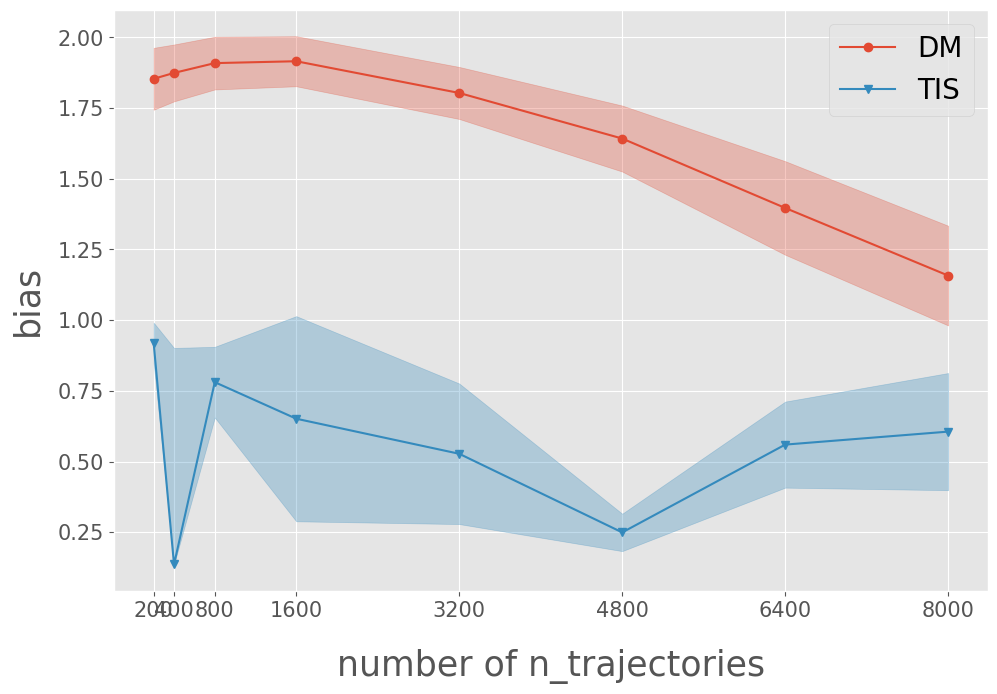

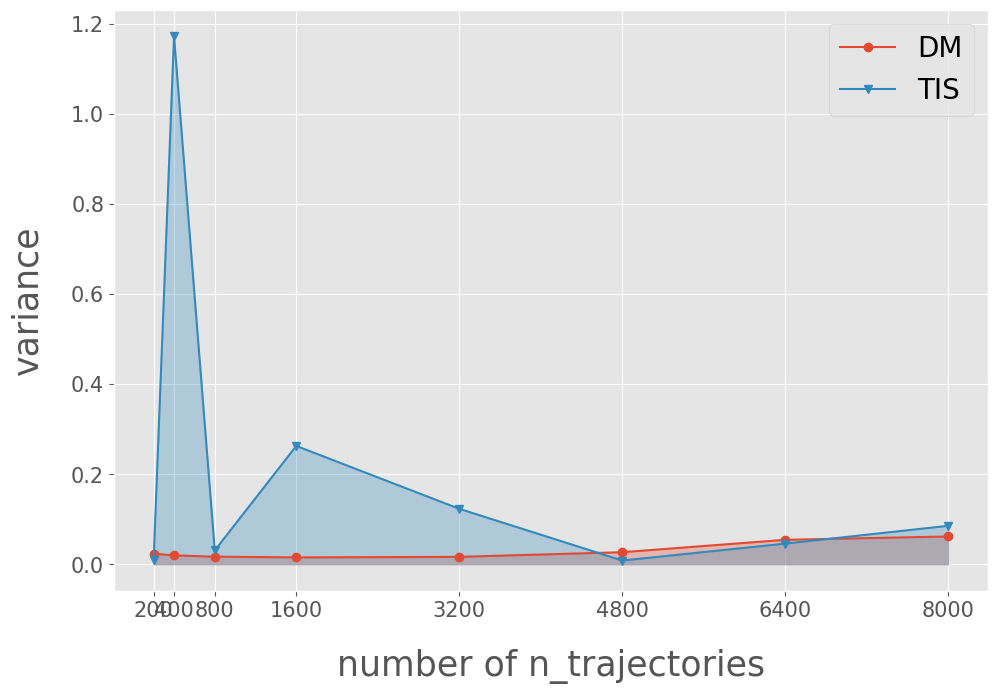

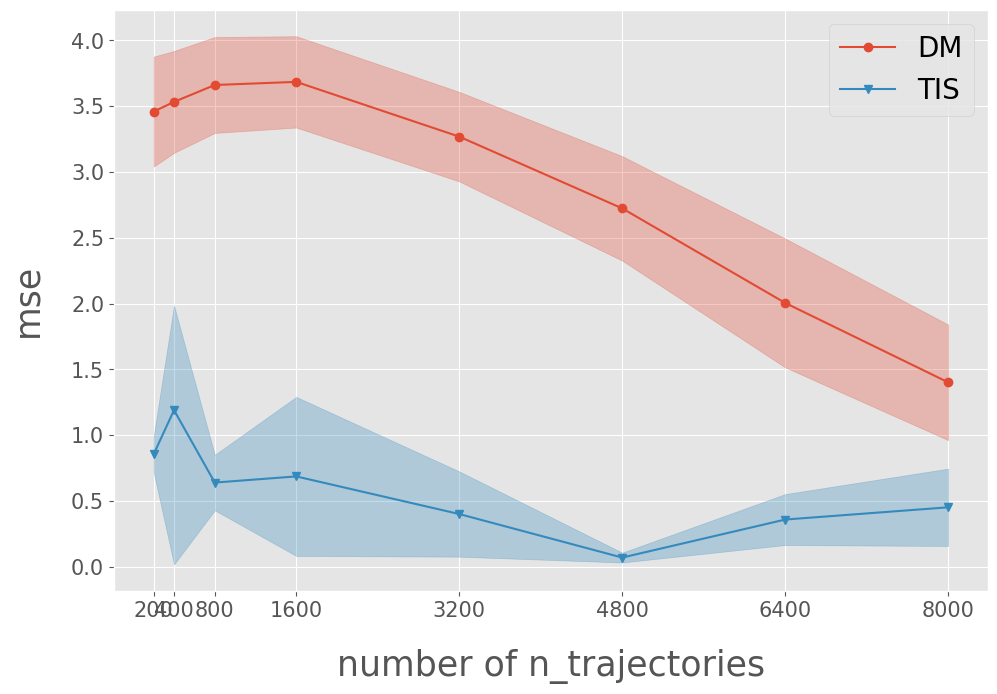

In [27]:
visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    ESTIMATORS=ESTIMATORS,
    estimators=estimators,
    x_scales=x_scales,
    x_label=x_label,
    # yscale_log=True,
    # xscale_log=True,
)